Referência da aula: https://jovian.ai/learn/deep-learning-with-pytorch-zero-to-gans/lesson/lesson-3-training-deep-neural-networks-on-a-gpu

## Preparação dos dados

Na aula anterior, treinamos um modelo de regressão logística para identificar dígitos manuscritos do conjunto de dados MNIST com uma precisão de cerca de 86%. O conjunto de dados consiste em imagens em escala de cinza de 28px por 28px de dígitos manuscritos (0 a 9) e rótulos para cada imagem indicando qual dígito ela representa. Aqui estão algumas imagens de amostra do conjunto de dados:

![mnist-sample](https://i.imgur.com/CAYnuo1.jpg)

Percebemos que é bastante desafiador melhorar a precisão de um modelo de regressão logística além de 87%, pois o modelo pressupõe uma relação linear entre as intensidades dos pixels e os rótulos das imagens. Nesta postagem, tentaremos aprimorá-lo usando uma rede neural *feed-forward* que pode capturar relações não lineares entre entradas e alvos.

Vamos começar instalando e importando os módulos e classes necessários do `torch`, `torchvision`, `numpy` e `matplotlib`.

In [3]:
import torch
import torchvision
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split
%matplotlib inline

# Use a white background for matplotlib figures
# Usando um fundo branco para as imagens do matplotlib
matplotlib.rcParams['figure.facecolor'] = '#ffffff'

In [4]:
dataset = MNIST(root='data/', download=True, transform=ToTensor())

image.shape torch.Size([1, 28, 28])
Label: 5


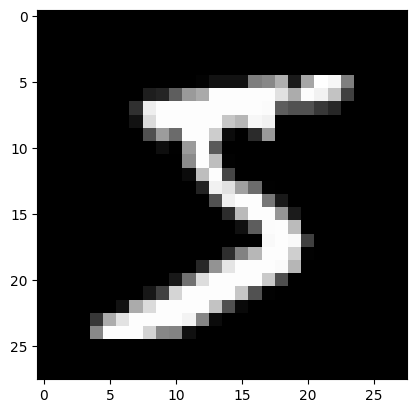

In [5]:
image, label = dataset[0]
print('image.shape',image.shape)
plt.imshow(image.permute(1,2,0), cmap='gray')
print('Label:', label)

image.shape: torch.Size([1, 28, 28])
Label: 0


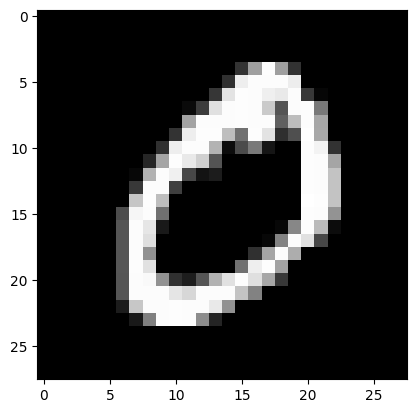

In [6]:
image, label = dataset[1]
print('image.shape:', image.shape)
plt.imshow(image.permute(1, 2, 0), cmap='gray')
print('Label:', label)

A seguir, vamos usar a função auxiliar `random_split` para reservar 10.000 imagens para nosso conjunto de validação.

In [7]:
val_size = 10000
train_size = len(dataset) - val_size
train_ds, val_ds = random_split(dataset, [train_size, val_size])
len(train_ds), len(val_ds)

(50000, 10000)

In [8]:
batch_size = 128

In [9]:
train_loader = DataLoader(train_ds, batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_ds, batch_size*2, num_workers=4, pin_memory=True)

Vamos visualizar um lote de dados em uma grade usando a função `make_grid` de `torchvision`. Também usaremos o método `.permute` no tensor para mover os canais para a última dimensão, conforme esperado por `matplotlib`.

images.shape torch.Size([128, 1, 28, 28])


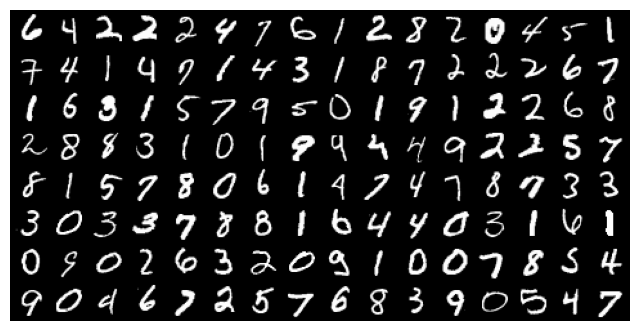

In [10]:
for images, _ in train_loader:
    print('images.shape', images.shape)
    plt.figure(figsize=(8,8))
    plt.axis('off')
    plt.imshow(make_grid(images, nrow=16).permute((1, 2, 0)))
    break

## Camadas ocultas, funções de ativação e não linearidade

Criaremos uma rede neural com duas camadas: uma _camada oculta_ e uma _camada de saída_. Além disso, usaremos uma _função de ativação_ entre as duas camadas. Vejamos um exemplo passo a passo para aprender como camadas ocultas e funções de ativação podem ajudar a capturar relacionamentos não lineares entre entradas e saídas.

Primeiro, vamos criar um lote de tensores de entradas. Nós achataremos as imagens `1x28x28` em vetores de tamanho `784`, para que possam ser passadas para um objeto `nn.Linear`.

In [11]:
for images, labels in train_loader:
    print('images.shape:', images.shape)
    inputs = images.reshape(-1, 784)
    print('inputs.shape', inputs.shape)
    break

images.shape: torch.Size([128, 1, 28, 28])
inputs.shape torch.Size([128, 784])


A seguir, vamos criar um objeto `nn.Linear`, que servirá como nossa camada _oculta_. Definiremos o tamanho da saída da camada oculta para 32. Este número pode ser aumentado ou diminuído para alterar a _capacidade de aprendizagem_ do modelo.

In [12]:
input_size = inputs.shape[-1]
hidden_size = 32
input_size, hidden_size

(784, 32)

In [13]:
layer1 = nn.Linear(input_size, hidden_size)

In [14]:
inputs.shape

torch.Size([128, 784])

In [15]:
layer1_outputs = layer1(inputs)
layer1_outputs.shape

torch.Size([128, 32])

Os vetores de imagem de tamanho `784` são transformados em vetores de saída intermediários de comprimento `32` realizando uma multiplicação da matriz de `entradas` com a matriz de pesos transpostos da `layer1` e adicionando o viés. Podemos verificar isso usando `torch.allclose`.

In [16]:
layer1_outputs_direct = inputs @ layer1.weight.t() + layer1.bias
layer1_outputs_direct.shape

torch.Size([128, 32])

In [17]:
torch.allclose(layer1_outputs, layer1_outputs_direct, 1e-3)

True

Assim, `layer1_outputs` e `inputs` têm um relacionamento linear, ou seja, cada elemento de `layer_outputs` é uma soma ponderada de elementos de `inputs`. Assim, mesmo enquanto treinamos o modelo e modificamos os pesos, a `layer1` só pode capturar relações lineares entre `inputs` e `outputs`.

<img src="https://i.imgur.com/inXsLuq.png" width="360">

A seguir, usaremos a função Unidade Linear Retificada (ReLU) como função de ativação das saídas. Tem a fórmula `relu(x) = max(0,x)`, ou seja, simplesmente substitui valores negativos em um determinado tensor pelo valor 0. ReLU é uma função não linear, como pode ser visto aqui visualmente:

<img src="https://i.imgur.com/yijV4xF.png" width="420">

Podemos usar o método `F.relu` para aplicar ReLU aos elementos de um tensor.

In [18]:
F.relu(torch.tensor([[1, -1, 0],
                    [-0.1, .2, 3]]))

tensor([[1.0000, 0.0000, 0.0000],
        [0.0000, 0.2000, 3.0000]])

Vamos aplicar a função de ativação a `layer1_outputs` e verificar se os valores negativos foram substituídos por 0.

In [19]:
relu_outputs = F.relu(layer1_outputs)
print('min(layer1_outputs):', torch.min(layer1_outputs).item())
print('min(relu_outputs):', torch.min(relu_outputs).item())

min(layer1_outputs): -0.7299017906188965
min(relu_outputs): 0.0


Agora que aplicamos uma função de ativação não linear, `relu_outputs` e `inputs` não têm um relacionamento linear. Referimo-nos a `ReLU` como a _função de ativação_, porque para cada entrada certas saídas são ativadas (aquelas com valores diferentes de zero) enquanto outras são desligadas (aquelas com valores zero)

A seguir, vamos criar uma camada de saída para converter vetores de comprimento `hidden_size` em `relu_outputs` em vetores de comprimento 10, que é a saída desejada do nosso modelo (já que existem

In [20]:
output_size = 10
layer2 = nn.Linear(hidden_size, output_size)

In [21]:
layer2_outputs = layer2(relu_outputs)
print(layer2_outputs.shape)

torch.Size([128, 10])


In [22]:
inputs.shape

torch.Size([128, 784])

Como esperado, `layer2_outputs` contém um lote de vetores de tamanho 10. Agora podemos usar esta saída para calcular a perda usando `F.cross_entropy` e ajustar os pesos de `layer1` e `layer2` usando gradiente descendente.

In [23]:
F.cross_entropy(layer2_outputs, labels)

tensor(2.3249, grad_fn=<NllLossBackward0>)

Assim, nosso modelo transforma `inputs` em `layer2_outputs` aplicando uma transformação linear (usando `layer1`), seguida por uma ativação não linear (usando `F.relu`), seguida por outra transformação linear (usando `layer2` ). Vamos verificar isso recalculando a saída usando operações matriciais básicas.

In [24]:
# Versão expandida de layer2(F.relu(layer1(inputs)))
outputs = (F.relu(inputs @ layer1.weight.t() + layer1.bias)) @ layer2.weight.t() + layer2.bias

In [25]:
torch.allclose(outputs, layer2_outputs, 1e-3)

True

Observe que `saídas` e `entradas` não possuem um relacionamento linear devido à função de ativação não linear `F.relu`. À medida que treinamos o modelo e ajustamos os pesos de `layer1` e `layer2`, agora podemos capturar relações não lineares entre as imagens e seus rótulos. Em outras palavras, a introdução da não linearidade torna o modelo mais poderoso e versátil. Além disso, como `hidden_size` não depende das dimensões das entradas ou saídas, variamos para aumentar o número de parâmetros dentro do modelo. Também podemos introduzir novas camadas ocultas e aplicar a mesma ativação não linear após cada camada oculta.

O modelo que acabamos de criar é chamado de rede neural. Uma _rede neural profunda_ é simplesmente uma rede neural com uma ou mais camadas ocultas. Na verdade, o [Teorema de Aproximação Universal] (http://neuralnetworksanddeeplearning.com/chap4.html) afirma que uma rede neural suficientemente grande e profunda pode calcular qualquer função arbitrária, ou seja, pode _aprender_ relações não lineares ricas e complexas entre entradas e alvos. aqui estão alguns exemplos:

* Identificar se uma imagem contém um gato ou um cachorro (ou [outra coisa](https://machinelearningmastery.com/introduction-to-the-imagenet-large-scale-visual-recognition-challenge-ilsvrc/))
* Identificar o gênero de uma música usando uma amostra de 10 segundos
* Classificar resenhas de filmes como positivas ou negativas com base em seu conteúdo
* Navegando em carros autônomos usando um feed de vídeo da estrada
* Traduzindo frases do inglês para o francês (e centenas de outros idiomas)
* Converter uma gravação de fala em texto e vice-versa
* E muitos mais...

É difícil imaginar como o simples processo de multiplicar entradas com matrizes inicializadas aleatoriamente, aplicar ativações não lineares e ajustar pesos repetidamente usando gradiente descendente pode produzir resultados tão surpreendentes. Os modelos de aprendizagem profunda geralmente contêm milhões de parâmetros, que juntos podem capturar relações muito mais complexas do que o cérebro humano pode compreender.

Se não tivéssemos incluído uma ativação não linear entre as duas camadas lineares, a relação final entre entradas e saídas ainda seria linear. Uma simples refatoração dos cálculos ilustra isso.

In [26]:
# Expansão de layer2(layer1(inputs))
outputs2 = (inputs @ layer1.weight.t() + layer1.bias) @ layer2.weight.t() + layer2.bias

In [27]:
# Criando uma única camada para substituir as duas camadas lineares
combined_layer = nn.Linear(input_size, output_size)

# Utiliza-se álgebra para chegar ao resultado a seguir
combined_layer.weight.data = layer2.weight @ layer1.weight
combined_layer.bias.data = layer1.bias @ layer2.weight.t() + layer2.bias

In [28]:
# combined_layer(inputs)
outputs3 = inputs @ combined_layer.weight.t() + combined_layer.bias

In [29]:
torch.allclose(outputs2, outputs3, 1e-3)

True

## Modelo

Agora estamos prontos para definir nosso modelo. Conforme discutido acima, criaremos uma rede neural com uma camada oculta. Aqui está o que isso significa:

* Em vez de usar um único objeto `nn.Linear` para transformar um lote de entradas (intensidades de pixel) em saídas (probabilidades de classe), usaremos dois objetos `nn.Linear`. Cada uma delas é chamada de _camada_ na rede.

* A primeira camada (também conhecida como camada oculta) transformará a matriz de entrada da forma `batch_size x 784` em uma matriz de saída intermediária da forma `batch_size x hidden_size`. O parâmetro `hidden_size` pode ser configurado manualmente (por exemplo, 32 ou 64).

* Aplicaremos então uma *função de ativação* não linear às saídas intermediárias. A função de ativação transforma elementos individuais da matriz.

* O resultado da função de ativação, que também tem tamanho `batch_size x hidden_size`, é passado para a segunda camada (também conhecida como camada de saída). A segunda camada o transforma em uma matriz de tamanho `batch_size x 10`. **Podemos usar esta saída para calcular a perda e ajustar os pesos usando gradiente descendente.**


Conforme discutido acima, nosso modelo conterá uma camada oculta. Aqui está o que parece visualmente:

<img src="https://i.imgur.com/eN7FrpF.png" width="480">


Vamos definir o modelo estendendo a classe `nn.Module` do PyTorch.

In [39]:
class MnistModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        self.linear1 = nn.Linear(input_size, hidden_size)
        self.linear2 = nn.Linear(hidden_size, output_size)
        
    def forward(self, xb):
        xb = xb.view(xb.size(0), -1)
        out = self.linear1(xb)
        out = F.relu(out)
        out = self.linear2(out)
        return out
    
    def training_step(self, batch):
        images, labels = batch
        out = self(images)
        loss = F.cross_entropy(out, labels)
        return loss
    
    def validation_step(self, batch):
        images, labels = batch
        out = self(images)
        loss = F.cross_entropy(out, labels)
        acc = accuracy(out, labels)
        return {'val_loss' : loss, 'val_acc': acc}
    
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()
        epoch_acc = torch.stack(batch_accs).mean()
        return {'val_loss' : epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['val_loss'], result['val_acc']))


Também precisamos definir uma função `accuracy` que calcula a precisão da previsão do modelo em um lote de entradas. Ela é usada em `validation_step` acima.

In [40]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [41]:
input_size = 784
hidden_size = 32
num_classes = 10

In [42]:
model = MnistModel(input_size, hidden_size, num_classes)

Vamos tentar gerar alguns resultados usando nosso modelo. Pegaremos o primeiro lote de 128 imagens do nosso conjunto de dados e as passaremos para o nosso modelo.

In [43]:
for images, labels in train_loader:
    outputs = model(images)
    loss = F.cross_entropy(outputs, labels)
    print('Loss:', loss.item())
    break

print('outputs.shape', outputs.shape)
print('Sample outputs :\n', outputs[:2].data)

Loss: 2.3062689304351807
outputs.shape torch.Size([128, 10])
Sample outputs :
 tensor([[-0.1549,  0.0999,  0.0466, -0.0268,  0.0257,  0.0779, -0.1148, -0.0331,
         -0.0668, -0.0632],
        [-0.1957,  0.1169, -0.0169, -0.0844,  0.0393, -0.0849, -0.0158, -0.0069,
          0.0197,  0.0353]])


## Treinamento do modelo

Definiremos duas funções: `fit` e `evaluate` para treinar o modelo usando a descida de gradiente e avaliar seu desempenho no conjunto de validação.

In [44]:
def evaluate(model, val_loader):
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        for batch in train_loader:
            loss = model.training_step(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        result = evaluate(model, val_loader)
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [45]:
model = MnistModel(input_size, hidden_size, output_size)

Vamos ver o desempenho do modelo no conjunto de validação com o conjunto inicial de pesos e vieses.

In [46]:
history = [evaluate(model, val_loader)]
history

[{'val_loss': 2.31620454788208, 'val_acc': 0.12363281100988388}]

A precisão inicial é de cerca de 10%, como seria de se esperar de um modelo inicializado aleatoriamente (já que ele tem 1 chance em 10 de acertar um rótulo ao adivinhar aleatoriamente).

Vamos treinar o modelo por cinco épocas e ver os resultados. Podemos usar uma taxa de aprendizado relativamente alta de 0,5.

In [47]:
history += fit(5, 0.5, model, train_loader, val_loader)

Epoch [0], val_loss: 0.2341, val_acc: 0.9300
Epoch [1], val_loss: 0.2034, val_acc: 0.9430
Epoch [2], val_loss: 0.1599, val_acc: 0.9534
Epoch [3], val_loss: 0.1680, val_acc: 0.9494
Epoch [4], val_loss: 0.1382, val_acc: 0.9599


 Vamos treinar o modelo por mais cinco épocas com uma taxa de aprendizado menor, de 0,1, para melhorar ainda mais a precisão.

In [48]:
history += fit(5, 0.1, model, train_loader, val_loader)

Epoch [0], val_loss: 0.1261, val_acc: 0.9633
Epoch [1], val_loss: 0.1230, val_acc: 0.9646
Epoch [2], val_loss: 0.1246, val_acc: 0.9646
Epoch [3], val_loss: 0.1232, val_acc: 0.9640
Epoch [4], val_loss: 0.1209, val_acc: 0.9645


Text(0.5, 1.0, 'Loss vs. No. of epochs')

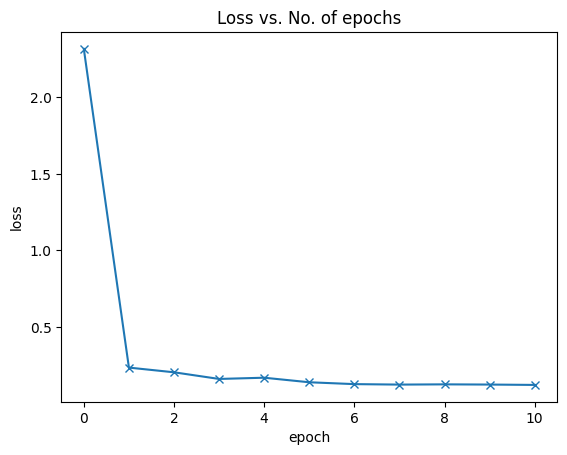

In [50]:
losses = [x['val_loss'] for x in history]
plt.plot(losses, '-x')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Loss vs. No. of epochs')

Text(0.5, 1.0, 'Accuracy vs. No. of epochs')

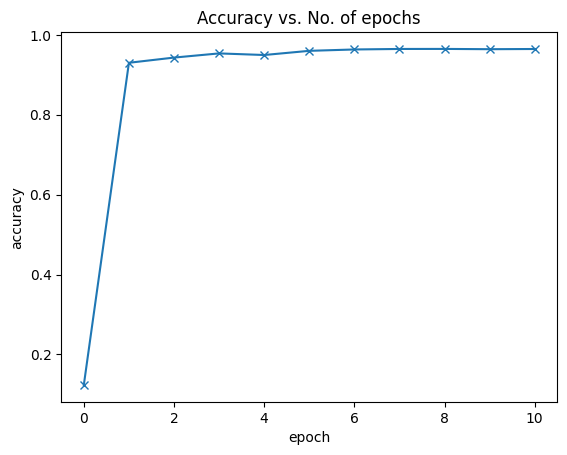

In [52]:
accuracies = [x['val_acc'] for x in history]
plt.plot(accuracies, '-x')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('Accuracy vs. No. of epochs')

Nosso modelo atual supera o modelo de regressão logística (que só conseguiu atingir cerca de 86% de precisão) por uma margem considerável! Ele atinge rapidamente uma precisão de 97%, mas não melhora muito além disso. Para melhorar ainda mais a precisão, precisamos tornar o modelo mais poderoso, aumentando o tamanho da camada oculta ou adicionando mais camadas ocultas com ativações.

## Testando com imagens individuais

Embora tenhamos monitorado a precisão geral de um modelo até agora, também é uma boa ideia analisar os resultados do modelo em algumas imagens de amostra. Vamos testar nosso modelo com algumas imagens do conjunto de dados de teste predefinido de 10.000 imagens. Começamos recriando o conjunto de dados de teste com a transformação `ToTensor`.

In [49]:
test_dataset = MNIST(root='data/',
                     train=False,
                      transform=ToTensor())

In [53]:
def predict_image(img, model):
    xb = img.unsqueeze(0)
    yb = model(xb)
    _, preds = torch.max(yb, dim=1)
    return preds[0].item()

Label: 7 , Predicted: 7


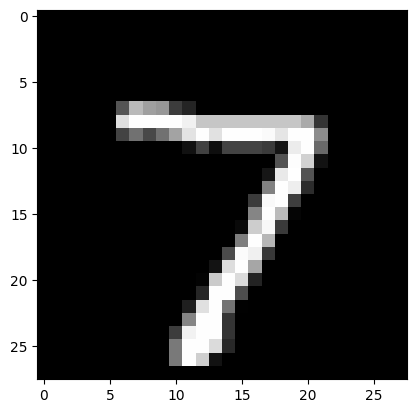

In [54]:
img, label = test_dataset[0]
plt.imshow(img[0], cmap='gray')
print('Label:', label, ', Predicted:', predict_image(img, model))

Label: 6 , Predicted: 2


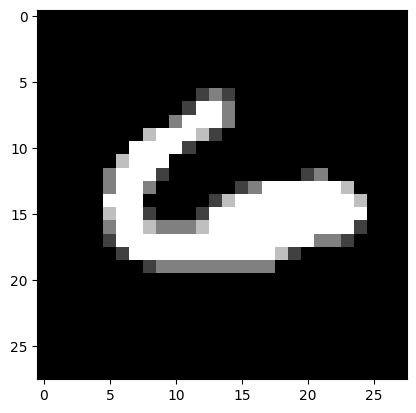

In [56]:
img, label = test_dataset[1800]
plt.imshow(img[0], cmap='gray')
print('Label:', label, ', Predicted:', predict_image(img, model))

Label: 9 , Predicted: 9


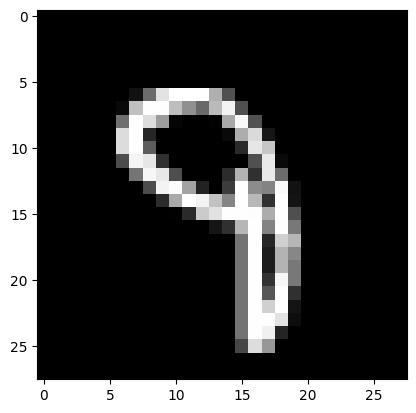

In [57]:
img, label = test_dataset[193]
plt.imshow(img[0], cmap='gray')
print('Label:', label, ', Predicted:', predict_image(img, model))

Identificar onde o nosso modelo tem um desempenho ruim pode nos ajudar a aprimorá-lo, coletando mais dados de treinamento, aumentando/diminuindo a complexidade do modelo e alterando os hipoparâmetros.

Como etapa final, vamos analisar também a perda geral e a precisão do modelo no conjunto de teste.

In [59]:
test_loader = DataLoader(test_dataset, batch_size=256)
result = evaluate(model, test_loader)
result

{'val_loss': 0.09786476939916611, 'val_acc': 0.970996081829071}

Esperamos que isso seja semelhante à precisão/perda no conjunto de validação. Caso contrário, talvez precisemos de um conjunto de validação melhor que tenha dados e distribuição semelhantes aos do conjunto de teste (que geralmente vem de dados do mundo real).